In [4]:
# Setup
import numpy as np

import symforce

symforce.set_symbolic_api("symengine")
symforce.set_log_level("warning")

# Set epsilon to a symbol for safe code generation.  For more information, see the Epsilon tutorial:
# https://symforce.org/tutorials/epsilon_tutorial.html
# symforce.set_epsilon_to_symbol()
# symforce.set_epsilon_to_number(1e-10)
symforce.set_epsilon_to_zero()

import symforce.symbolic as sf
from symforce import dataclass
from symforce.notebook_util import set_notebook_defaults

set_notebook_defaults()

# Generate synthetic data

In [5]:
from dataclasses import dataclass, field
import math
from typing import Tuple


@dataclass
class CameraConfig:
    t_x: float
    t_y: float
    t_z: float
    yaw: float
    pitch: float
    roll: float
    f_x: float = 100
    f_y: float = 100
    c_x: float = 250
    c_y: float = 250
    width: int = 500
    height: int = 500


def get_camera_calibration_model(config: CameraConfig) -> sf.CameraCal:
    return sf.SphericalCameraCal(
        focal_length=(config.f_x, config.f_y),
        principal_point=(config.c_x, config.c_y),
        distortion_coeffs=(0.1, 0.005, 0.02, 0.02, 0.0, 0.0),
        critical_theta=np.deg2rad(170),
    )


def get_camera_image_size(config: CameraConfig) -> Tuple[int, int]:
    return (config.width, config.height)


def get_camera_pose(config: CameraConfig) -> sf.Pose3:
    return sf.Pose3(
        R=sf.Rot3.from_yaw_pitch_roll(config.yaw, config.pitch, config.roll),
        t=sf.V3(config.t_x, config.t_y, config.t_z),
    )


def create_camera_from_config(config: CameraConfig) -> sf.PosedCamera:
    return sf.PosedCamera(
        pose=get_camera_pose(config),
        calibration=get_camera_calibration_model(config),
        image_size=get_camera_image_size(config),
    )


class VehicleSensors:
    def __init__(self):
        self.camera_configs = {
            "front": CameraConfig(
                t_x=2.5,
                t_y=0.0,
                t_z=0.5,
                yaw=-math.pi / 2,
                pitch=0.0,
                roll=-math.pi / 2,
            ),
            "left": CameraConfig(
                t_x=1.0, t_y=1.0, t_z=0.5, yaw=0.0, pitch=0.0, roll=-math.pi / 2
            ),
            "right": CameraConfig(
                t_x=1.0, t_y=-1.0, t_z=0.5, yaw=math.pi, pitch=0.0, roll=-math.pi / 2
            ),
            "rear": CameraConfig(
                t_x=-0.5,
                t_y=0.0,
                t_z=0.5,
                yaw=math.pi / 2,
                pitch=0.0,
                roll=-math.pi / 2,
            ),
        }
        self.cameras = {
            cid: create_camera_from_config(cfg)
            for cid, cfg in self.camera_configs.items()
        }


class Vehicle:
    def __init__(self, pose: sf.Pose3):
        self.sensors = VehicleSensors()
        # vehicle pose in the world frame, world_T_body
        self.pose = pose

    def _project_world_point_to_camera(
        self, camera: sf.PosedCamera, world_point: sf.V3
    ) -> Tuple[sf.V2, bool]:
        body_T_world = self.pose.inverse()
        camera_T_body = camera.pose.inverse()
        return camera.pixel_from_camera_point(
            camera_T_body * body_T_world * world_point
        )

    def project_world_point_to_camera(
        self, camera_id: str, world_point: sf.V3
    ) -> Tuple[sf.V2, bool]:
        camera = self.sensors.cameras[camera_id]
        return self._project_world_point_to_camera(camera, world_point)


@dataclass
class Observation:
    landmark_id: int
    u: float
    v: float


@dataclass
class VehiclePerceptions:
    front: list[Observation] = field(default_factory=list)
    left: list[Observation] = field(default_factory=list)
    right: list[Observation] = field(default_factory=list)
    rear: list[Observation] = field(default_factory=list)


class World:
    def __init__(self):
        self._world_points = np.indices((11, 11), dtype=float).reshape(2, -1).T
        self._perceptions = VehiclePerceptions()

    @property
    def points(self) -> np.ndarray:
        return self._world_points

    @property
    def perceptions(self) -> VehiclePerceptions:
        return self._perceptions

    def get_perceptions_array(self, camera_id: str) -> np.ndarray:
        return np.array([[o.u, o.v] for o in getattr(self._perceptions, camera_id)])

    def gen_perceptions(self, vehicle: Vehicle) -> dict:
        for point_id, world_point in enumerate(self._world_points):
            for camera_id in ["front", "left", "right", "rear"]:
                camera_pixel, is_visible = vehicle.project_world_point_to_camera(
                    camera_id, sf.V3(world_point[0], world_point[1], 0.0)
                )
                if bool(is_visible):
                    getattr(self._perceptions, camera_id).append(
                        Observation(
                            point_id, float(camera_pixel[0]), float(camera_pixel[1])
                        )
                    )


world = World()

vehicle = Vehicle(
    sf.Pose3(R=sf.Rot3.from_yaw_pitch_roll(0.0, 0.0, 0.0), t=sf.V3(4.0, 0.0, 0.0))
)

world.gen_perceptions(vehicle)


In [ ]:
import matplotlib.pylab as plt

%matplotlib widget

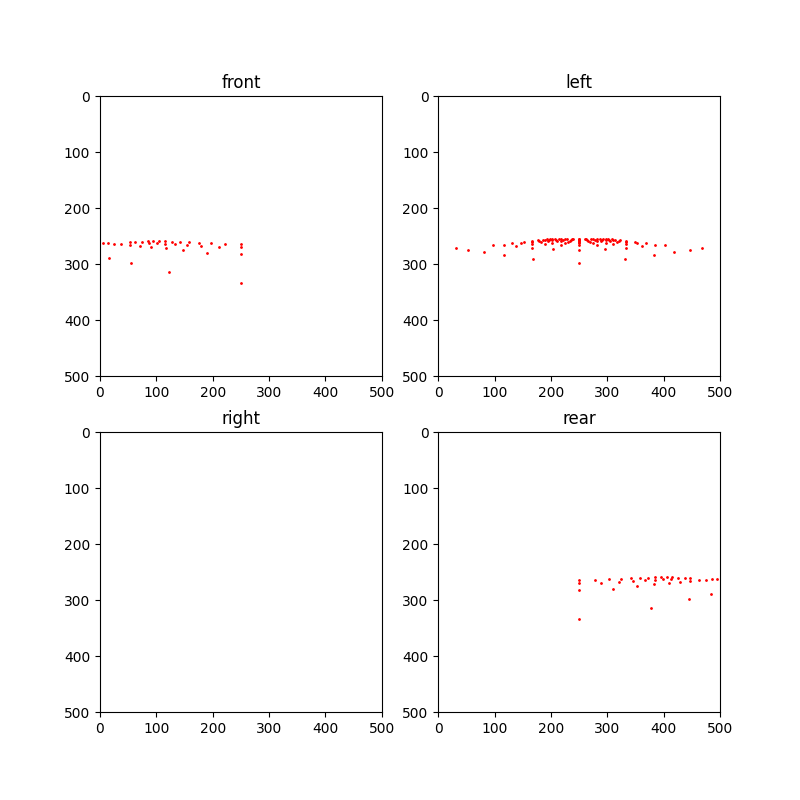

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, camera_id in enumerate(["front", "left", "right", "rear"]):
    multi_index = np.unravel_index(i, ax.shape)
    observations_uv = world.get_perceptions_array(camera_id)
    if len(observations_uv):
        ax[multi_index].scatter(
            observations_uv[:, 0], observations_uv[:, 1], s=1, c="red"
        )
    ax[multi_index].set(xlim=(0, 500), ylim=(0, 500), title=camera_id)
    ax[multi_index].invert_yaxis()


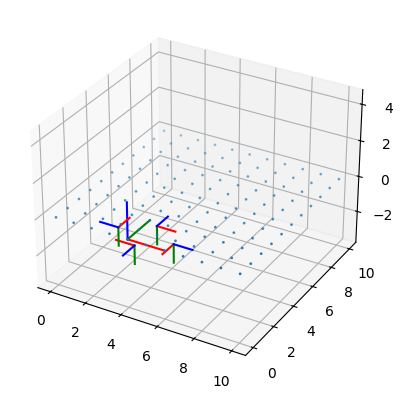

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.transformations import plot_transform


# Helper to convert Pose3 to a 4x4 homogeneous matrix.
def pose3_to_homogeneous(pose: sf.Pose3) -> np.ndarray:
    T = np.eye(4)
    T[:3, :3] = (
        pose.R.to_rotation_matrix().to_numpy()
    )  # Assuming pose.R is a 3x3 rotation matrix.
    T[:3, 3] = pose.t  # Assuming pose.t is a 3-element translation vector.
    return T


fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the vehicle's body frame in world coordinates.
T_body_world = pose3_to_homogeneous(vehicle.pose)
# plot_transform(T_body_world, ax=ax, s=1.0, label="Body Frame")
plot_transform(ax, T_body_world, s=2.0)

for i, camera_id in enumerate(["front", "left", "right", "rear"]):
    cam = vehicle.sensors.cameras[camera_id]
    T_cam_body = pose3_to_homogeneous(cam.pose)
    T_cam_world = (
        T_body_world @ T_cam_body
    )  # world_T_camera = world_T_body * body_T_camera
    plot_transform(ax, T_cam_world, s=1.0)

ax.set(xlim=(-2, 10), ylim=(-2, 10), zlim=(-2, 10))
ax.scatter(
    world.points[:, 0], world.points[:, 1], np.zeros_like(world.points[:, 0]), s=1
)
ax.axis("equal")
plt.show()

In [19]:
# # body w.r.t. world frame
# world_T_body = sf.Pose3.symbolic("world_T_body")
# # odometry
# body_T_body_next = sf.Pose3.symbolic("body_T_body_next")

# world_T_body_next = world_T_body * body_T_body_next

# # camera w.r.t. body frame
# body_T_camera = sf.Pose3.symbolic("body_T_camera")

# # camera calibration
# camera_calibration = sf.LinearCameraCal.symbolic("camera_calibration")

# # world point
# world_point = sf.V3.symbolic("world_point")

# # project world point to image
# body_T_world = world_T_body_next.inverse()
# camera_T_body = body_T_camera.inverse()
# camera_point = camera_T_body * body_T_world * world_point
# image_point, is_valid = camera_calibration.project(camera_point)

# # now we have world points transformed to image points
# # and we also have the validity of the projection
# # we also know the current detections in the image
# # so we do matching and then we can define the loss
# print(is_valid)
